#Localización del sonido por animales binaurales.

T. N. Parks y E. W. Rubel sugirieron un mecanismo de cómo los pollos pueden localizar sonidos empleando una red neuronal simple. La red neuronal se muestra en la siguiente figura:

![](http://localhost:8888/files/photo.JPG)

Esta red describe caracterísitcas escenciales del núcleo auditivo de los pollos. En este modelo cada oído tiene varios axones que salen de él, y cada uno de estos axones llega a una direfente neurona central localizada en el HIPOTALAMO O ALGUN LUGAR DEL CEREBRO (BUSCAR). Cuando una de las neuronas centrales recibe simultaneamente estimulación de ambos lados, derecho e ixquierdo, ésta dispara un potencial de acción. Si solo un lado la excita, no hay disparo. La señal producida por una de estas neuronas centrales cuasa una respuesta muscular, y el pollo responde ubicando de donde proviene el sonido girando su cabeza.

##Un modelo de axón.

Toma tiempo para un potencial de acción recorrer todo un axón, y también hay un tiempo que tardan en realizarse las sinapsis entre dos neuronas. 
Existen varias maneras de modelar los axones como líneas de transmisión electricas. Y en [REFERENCIA DEL LIBRO] se modelan utilizando los ya introducidos osciladores controlados por voltaje (VCON). En este modelo para un axón, cada VCON actúa como un patch de membrana de axón, y el acoplamiento está modelado por filtros pasabajos:
    $$ \rightarrow FPB  \rightarrow z_j \rightarrow VCON \rightarrow x_j $$
    
Entonces cada neurona de la red, se piensa como un VCON y se asume que son excitables. Un voljtae lo suficientemente alto introducido por un sonido por alguno de los dos lados del pollo, pasa a través del circuito y eventualmente acaba en el otro extremo. Cada VCON introduce una nueva desviación de fase o retraso temporal, pues al potencial de disparo le toma algún tiempo llegar al otro extremo.

##Una red binaural

Una onda acústica entrando en un oído causa que la membrana basilar vibre en una región que corresponde a la frecuencia de la onda acústica. Como respuesta pequeñas céluas de cabello en esa región exitan un axón de una neurona causando que ésta dispare un potencial de acción. 
Este proceso se modela con un VCON. La señal causada por un estímulo en el oído derecho llega a una neurona central que reacciona contrayendo algunos músculos haciendo rotar al pollo la cabeza hacia la derecha, lo mismo sucede cuando entra un estímulo de lado derecho. el sistema de ecuaciones es el siguiente:

$$\dot{x}_0=\omega _0+V(x_0) +L(t) $$

$$\ddot{x}_j+\dot{x}_j=\omega_j+V(x_j)+V(x_{j-1})$$

$$\ddot{y}_j+\dot{y}_j=\mu _j +V(y_j)+V(x_j)+V(z_j)$$

$$\dot{z}_j=\omega _j + V(z_j)+V(z_{j-1})$$

$$\dot{z_0}=\omega _0 +V(z_0)+R(t)$$

para $j=1,..,N$ . Un pulso entrando por el lado derecho seguido de un entrando por el oído izquierdo produce pulsos moviéndose a lo largo de las respectivas cadenas de axones.

Se necesita hacer un cambio de variables para pasar aun sistema de ecuaciones de primer orden:

$$\dot{x_j}=u_j \  ; \ \dot{y}=v_j $$

Con esto el sistema se transforma en:

$$\dot{x}_0=\omega _0+V(x_0) +L(t) $$

$$\dot{x_j}=u_j$$

$$\dot{u}_j=\omega_j+V(x_j)+V(x_{j-1})-\dot{x}_j$$

$$\dot{y}=v_j$$

$$\dot{v}_j=\mu _j +V(y_j)+V(x_j)+V(z_j)-\dot{y}_j$$

$$\dot{z}_j=\omega _j + V(z_j)+V(z_{j-1})$$

$$\dot{z_0}=\omega _0 +V(z_0)+R(t)$$

**Para simplificar los cálculos**, comenzaremos con una red más pequeña de tan sólo 3 neuronas, dos neuronas que están conectadas al oído izquierdo y derecho respectivamente y una neurona central :

$$L \leftrightarrow N \leftrightarrow R $$

In [1]:
using PyPlot
using TaylorSeries
println(VERSION)

using Compat;

INFO: Loading help data...


0.3.11


In [2]:
function step{T<:Number}(x::Taylor1{T},eps::T)
    orden=length(x.coeffs)
    hs=Number[]
    for i in 1:orden #esto lo hacemos para evitar problemas con los coeficientes de Taylor que 
        #son cero
        if x.coeffs[i]!=0
            push!(hs,x.coeffs[i])
        end 
    end 
    orden=length(hs)
    p1=1/orden
    p2=1/(orden-1)
    den1=hs[orden]
    den2=hs[orden-1]
    h1=(abs(eps/den1))^p1
    h2=(abs(eps/den2))^p2
    h=min(h1,h2)
    #println(hs)

    return h
end 
    

step (generic function with 1 method)

In [3]:
function d{T<:Real}(x::Taylor1{T}) # La función pide un Taylor
    res=(x+((x^2)^0.5))/2.0
    return res
#end    
#function positive{T<:Number}(x::Taylor1{T})
#    obj=(x+(x^2)^0.5)/2
 #   return obj
end 

d (generic function with 1 method)

In [4]:
function tanh(x::Taylor1)
     ap1 = exp(2.0*(x))
    res1 = (ap1-1.0)/(ap1+1.0)
    return res1
end 

tanh (generic function with 1 method)

In [5]:
function atoll3(x::Taylor1,y::Taylor1,z::Taylor1,σ::Number)
    f1=5.0*(1+σ+cos(x)-cos(y))
    f2=0.04*(1+cos(y)+tanh(2*cos(x)-10*cos(y)))
    f3=10.0*(0.1+cos(z)-cos(y))
    return f1,f2,f3
end 

atoll3 (generic function with 1 method)

In [6]:
function atollpositive3(x::Taylor1,y::Taylor1,z::Taylor1,σ::Number)
      Lyi = d(cos(y))
        Dx1 = 5.0*(1.0+cos(x)-d(cos(y))+σ)
        Dy1 = 0.04*(1.0+cos(y)+tanh(2.0*d(cos(x)-10.0*Lyi)))
        Dz1 = 10.0*(0.1+cos(z)-d(cos(y)))
    #f1=5.0*(1+σ+cos(x)-positive(cos(y)))
    #f2=0.04*(1+cos(y)+tanh(2*positive(cos(x))-10*positive(cos(y))))
    #f3=10.0*(0.1+cos(z)-positive(cos(y)))
    return Dx1,Dy1,Dz1#f1,f2,f3
    
end 

atollpositive3 (generic function with 1 method)

In [7]:
function xjetatoll3{T<:Number}(arr::Array{T,1},orden::Int,g::Function,σ::Number) #AQUI ESTÁ MI ERROR!!!! ENCONTRARLO!!
    xjet=zeros(orden)
    yjet=zeros(orden)
    zjet=zeros(orden)
    xjet[1]=arr[1] #cond. iniciales
    yjet[1]=arr[2]
    zjet[1]=arr[3]
    fx=zeros(orden)
    fy=zeros(orden)
    fz=zeros(orden)
    for k in 1:orden-1
        ax=Taylor1(xjet)
        ay=Taylor1(yjet)
        az=Taylor1(zjet)
        bx,by,bz=g(ax,ay,az,σ)
        fx[k]=bx.coeffs[k]
        fy[k]=by.coeffs[k]
        fz[k]=bz.coeffs[k]
        xjet[k+1]=fx[k]/(k)
        yjet[k+1]=fy[k]/(k)
        zjet[k+1]=fz[k]/k#OJO CON LA REALACION DE RECURRENCIA
    end 
    xaprox=Taylor1(xjet,orden)
    yaprox=Taylor1(yjet,orden)
    zaprox=Taylor1(zjet,orden)
    return xaprox,yaprox,zaprox
end 
    
    

xjetatoll3 (generic function with 1 method)

In [8]:
function integrate{T<:Number}(initial::Array{T,1},orden::Int,g::Function,tmax::T,eps::T)
    t=T[]#t=zeros(iter)
    xsolutions=T[]#xsolutions=zeros(iter)
    ysolutions=T[]#ysolutions=zeros(iter)
    zsolutions=T[]
    t0=initial[1]
    push!(t,initial[1])#t[1]=t0 #tiempo inicial
    push!(xsolutions,initial[2])# xsolutions[1]=x0
    push!(ysolutions,initial[3])  #ysolutions[1]=y0#condicion inicial
    push!(zsolutions,initial[4])
    contador =0
    i=0
    σ=0.5
    while t0<tmax #for i in 1:iter-1
        i=i+1
        arregloaux=[xsolutions[i],ysolutions[i],zsolutions[i]]
        xaprox,yaprox,zaprox=xjetatoll3(arregloaux,orden,g,σ)
        #h1,h2,h3=step(xaprox),step(yaprox),step(zaprox)
        h=step(xaprox,eps)#h=min(h1,h2,h3)#println(h)
        contador=contador+h
        t0=t0+h#t[i+1]=t[i]+h
        xaux=evaluate(xaprox,h)
        yaux=evaluate(yaprox,h)
        zaux=evaluate(zaprox,h)
        
        push!(t,t0)
        push!(xsolutions,xaux) # xsolutions[i+1]=evaluate(xaprox,h)
        push!(ysolutions,yaux) # ysolutions[i+1]=evaluate(yaprox,h)
        push!(zsolutions,zaux)
        
    end 
    println("h total es ",contador)
    return t,xsolutions,ysolutions,zsolutions
end ;
    

In [9]:
function graficar{T<:Number}(arreglo::Array{T,1},orden::Int,g::Function,tmax::T,eps::T)
    tatoll,xatoll,yatoll,zatoll=integrate(arreglo,orden,g,tmax,eps)
    cosx=cos(xatoll)
    cosy=cos(yatoll)+2
    cosz=cos(zatoll)+4;
    plot(tatoll,cosx)
    plot(tatoll,cosy)
    plot(tatoll,cosz)
    axis([0,1000,-1,5]);
end 

graficar (generic function with 1 method)

h total es 2500.0031756125873


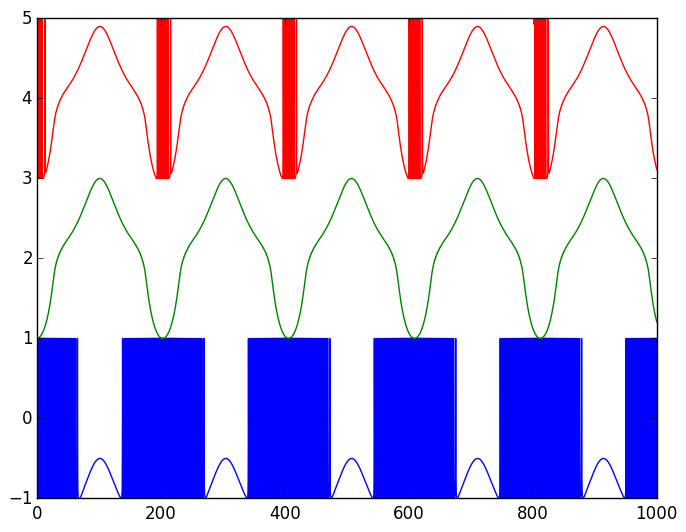

In [10]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,10,atoll3,2500.0,1e-20);

h total es 2500.000573052258


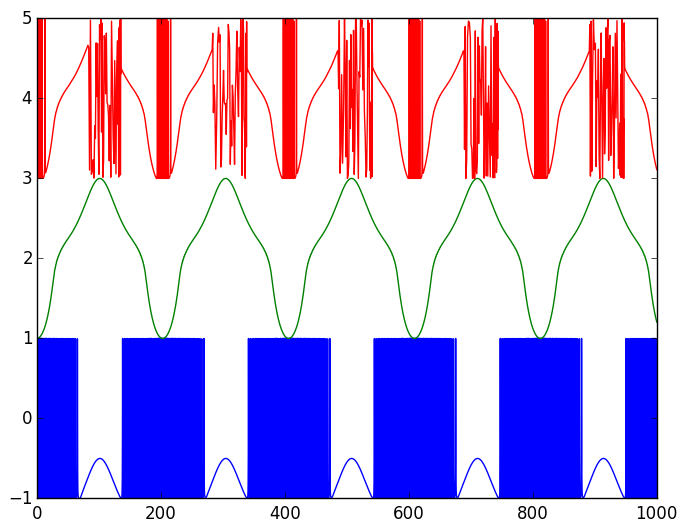

In [11]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,10,atoll3,2500.0,1e-10);

h total es 2500.027707745919


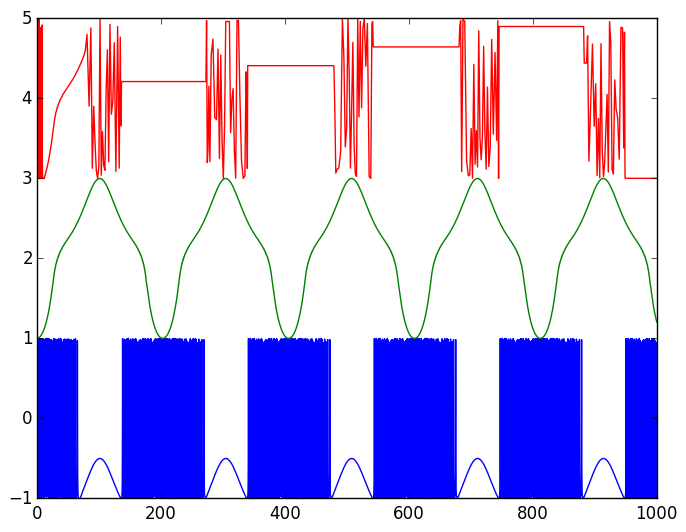

In [12]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,20,atoll3,2500.0,1e-10);

h total es 2500.0214030078105


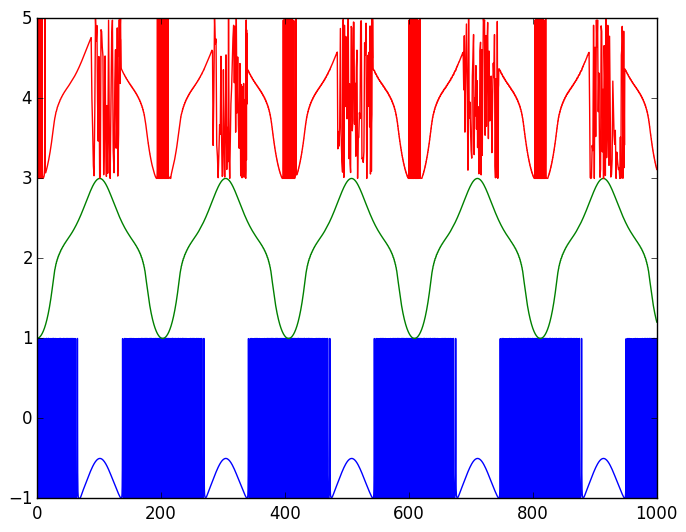

In [13]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,15,atoll3,2500.0,1e-15);

h total es 2500.003400860063


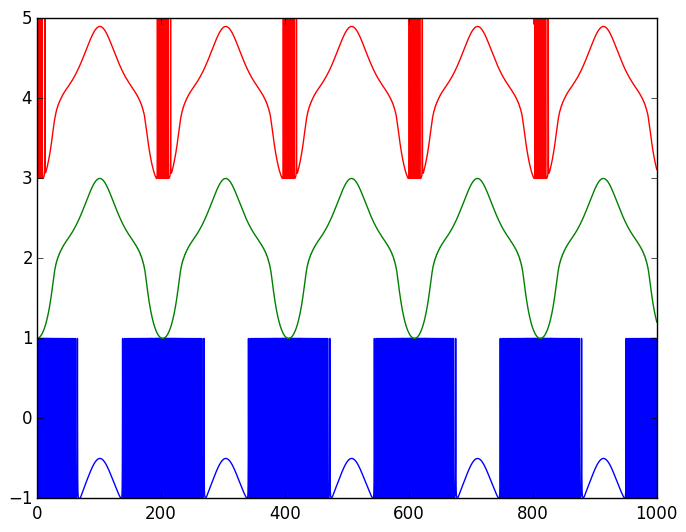

In [14]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,10,atoll3,2500.0,1e-15);

h total es 2500.013719320147


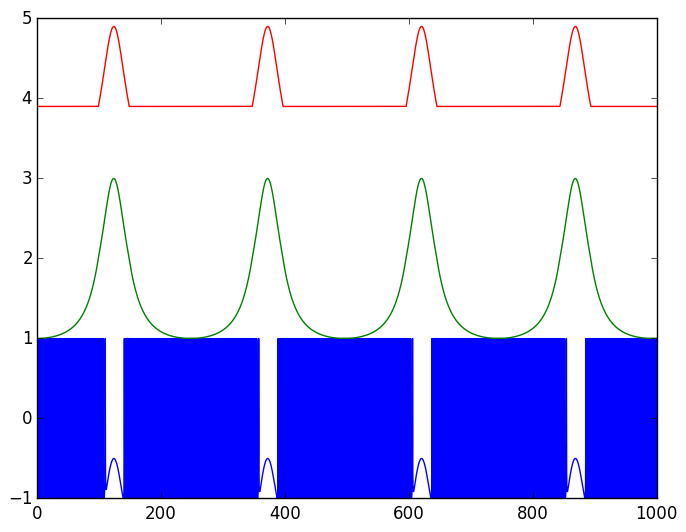

In [20]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,13,atollpositive3,2500.0,1e-15);

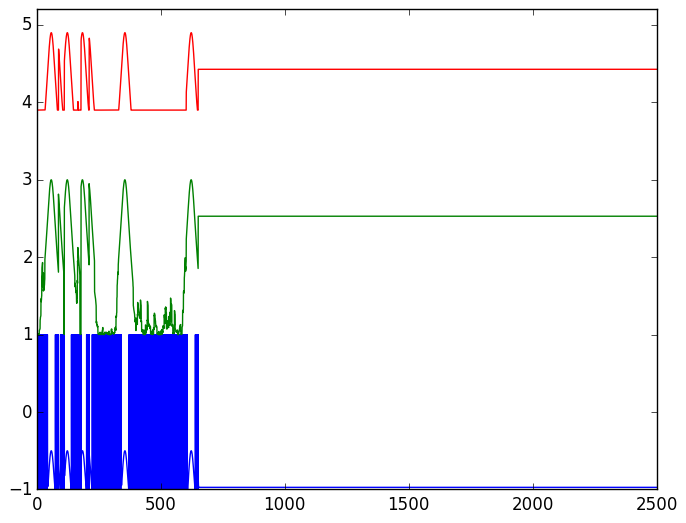

In [26]:
plot(tatoll,cosx)
plot(tatoll,cosy)
plot(tatoll,cosz)
axis([0,5000,-1,5.2]);

In [28]:
condiciones_iniciales=[0.0,-π,-π,-π]
tatoll,xatoll,yatoll,zatoll=integrate(condiciones_iniciales,25,atollpositive3,2500.0)
cosx=cos(xatoll) #aqui use N=25, eps=1e-20
cosy=cos(yatoll)+2
cosz=cos(zatoll)+4;

h total es 2500.1422390374773


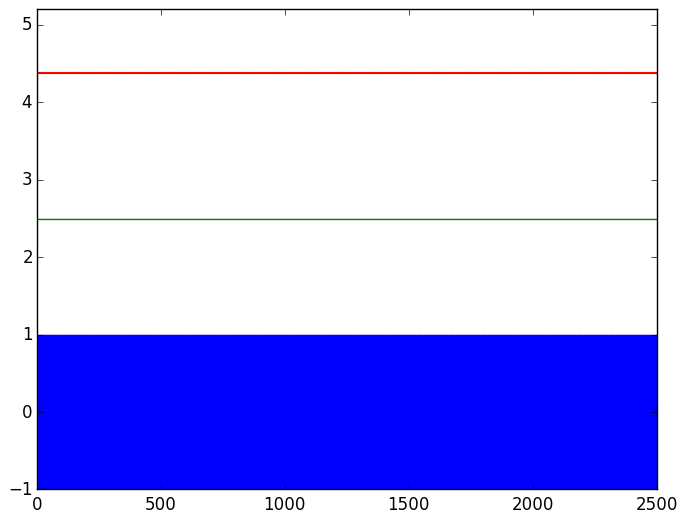

In [29]:
plot(tatoll,cosx)
plot(tatoll,cosy)
plot(tatoll,cosz)
axis([0,2500,-1,5.2]);

h total es 2500.1422390374773


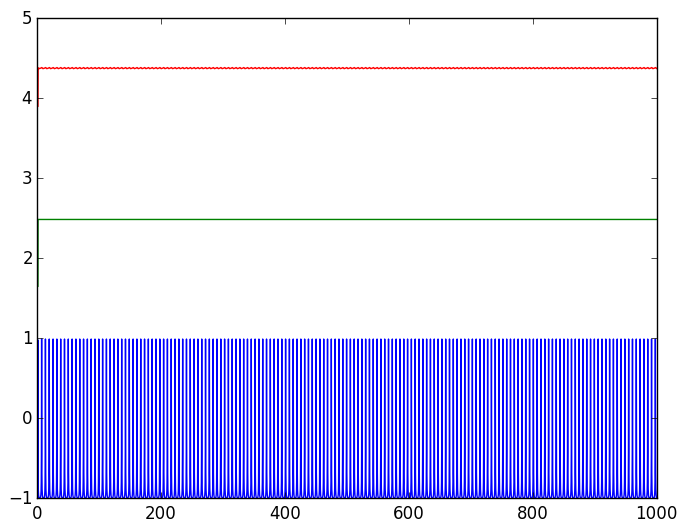

In [21]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,25,atollpositive3,2500.0,1e-20);

In [ ]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,5,atollpositive3,2500.0,1e-15);

In [ ]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,5,atollpositive3,2500.0,1e-20);

In [ ]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,5,atollpositive3,2500.0,1e-25);

In [ ]:
condiciones_iniciales=[0.0,-π,-π,-π]
graficar(condiciones_iniciales,10,atollpositive3,2500.0,1e-15);